In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad


In [31]:
# Funcao pra criar um polinomio cubico
def polinomio_cubico(a, b, c, d, x, x0):
    """
    Avalia um polinômio cúbico em um ponto x dado os coeficientes a, b, c, d e o ponto x0.
    """
    return a * (x - x0)**3 + b * (x - x0)**2 + c * (x - x0) + d
    

In [32]:
# Função para criar as matrizes e o vetor de constantes
def spline_cubica(x, x_0, y_0, t=0, r=0):
    """
    Gera a spline cúbica natural para um conjunto de pontos x_0 e y_0.
    
    Parâmetros:
    - x: domínio do spline S_3 (valores onde queremos avaliar a spline)
    - x_0: pontos de suporte no eixo x
    - y_0: valores de suporte no eixo y correspondentes a x_0
    - t, r: condições de contorno (derivadas segundas nos extremos)
    
    Retorna:
    - y_result: valores da spline cúbica avaliados nos pontos de x
    """
    
    n = len(x_0) - 1  # Número de intervalos
    h = np.diff(x_0)  # Calcula os hi = x_i+1 - x_i
    u = np.zeros(n-1)  # Vetor principal da matriz
    v = np.zeros(n-1)  # Vetor constante
    b = np.zeros(n-1)  # Vetor de incógnitas

    # Preenchendo os vetores u e v
    for i in range(1, n):
        u[i-1] = 2 * (h[i-1] + h[i])  # ui = 2(hi-1 + hi)
        v[i-1] = (3/h[i]) * (y_0[i+1] - y_0[i]) - (3/h[i-1]) * (y_0[i] - y_0[i-1])  # vi
    
    # Ajuste das condições de contorno
    v[0] -= h[0] * t / 2  
    v[-1] -= h[-1] * r / 2  
    
    # Criando a matriz tridiagonal
    A = np.zeros((n-1, n-1))
    for i in range(n-1):
        A[i, i] = u[i] 
        if i > 0:
            A[i, i-1] = h[i-1]  
        if i < n-2:
            A[i, i+1] = h[i]  
    
    # Resolvendo o sistema para obter os coeficientes b
    b = np.linalg.solve(A, v)
    b = np.concatenate(([t], b, [r]))  # Adicionando condições de contorno nas extremidades
    
    # Calculando os coeficientes a e c
    a = np.diff(b) / (3 * np.diff(x_0))
    c = (np.diff(y_0) / np.diff(x_0)) - (np.diff(x_0) * (b[1:] + 2 * b[:-1]) / 3)

    # Avaliando o spline cúbico nos valores de x
    y_result = np.zeros(len(x))  # Inicializando o array de resultados
    
    for j, xi in enumerate(x):  # Para cada ponto xi onde queremos avaliar a spline
        # Encontrando o intervalo correto onde xi está localizado
        for i in range(len(x_0) - 1):
            if x_0[i] <= xi < x_0[i+1]:
                # Avaliando o polinômio cúbico correspondente ao intervalo [x_0[i], x_0[i+1]]
                y_result[j] = polinomio_cubico(a[i], b[i], c[i], y_0[i], xi, x_0[i])
                break
    
    # Caso o valor de xi seja o último ponto (para evitar exclusão de xi == x_0[-1])
    if x[-1] == x_0[-1]:
        y_result[-1] = y_0[-1]
    
    return y_result
    

In [33]:
def regra_trapezio(f, a, b, n):
    """
    Calcula a integral definida de uma função f(x) no intervalo [a, b]
    usando a Regra do Trapézio Generalizada.
    
    Parâmetros:
    f: função que deseja integrar.
    a: limite inferior da integral.
    b: limite superior da integral.
    n: número de subintervalos.
    
    Retorna:
    Aproximação numérica da integral definida de f(x) no intervalo [a, b].
    """
    h = (b - a) / n  # Tamanho do subintervalo
    soma = (f(a) + f(b))/2  # Termos f(a) e f(b)

    # Soma dos termos intermediários
    for i in range(1, n):
        soma += f(a + i * h)

    return soma * h  # Multiplica pelo tamanho do intervalo

In [34]:
# Calculo do Erro e de v

# Pontos fornecidos
x = np.array([-2, -3/2, -1, -1/2, 1/2, 1, 3/2, 2])
y = np.array([0, 1/2, 1, 3/2, 3/2, 1, 1/2, 0])

# Função da borda 
T = lambda x: np.where(x < 0, 2 + x, 2 - x)

# Função para calcular a distância Q
def calcular_Q(v, x_0, y_0, m):

    n = len(x_0)
    
    x_0 = np.insert(x_0, n//2, 0)
    y_0 = np.insert(y_0, n//2, v)

    # Distância Q definida como integral da diferença quadrada da funcao Spline e da Funcao Borda
    integrando = lambda x: (spline_cubica(np.array([x]), x_0, y_0) - T(x))**2 # funcao da diferenca ao quadrado
    Q1 = regra_trapezio(integrando, -2, -1/2, m)
    Q2 = regra_trapezio(integrando, 1/2, 2, m)
    
    return Q1 + Q2

# Valores possíveis para o ponto central (v)
n = 100
m = 100
v_vals = np.linspace(3/2, 2, n)
Q_vals = np.array([calcular_Q(v, x, y, m) for v in v_vals])

# Encontrando o valor de v que minimiza Q
Q_minimo = np.min(Q_vals)
v_otimo = v_vals[np.argmin(Q_vals)]

print(f"Erro mínimo de Q: {np.min(Q_vals)}")
print(f"Valor ótimo de v: {v_otimo}")


Erro mínimo de Q: 1.479114197289397e-33
Valor ótimo de v: 1.8333333333333335


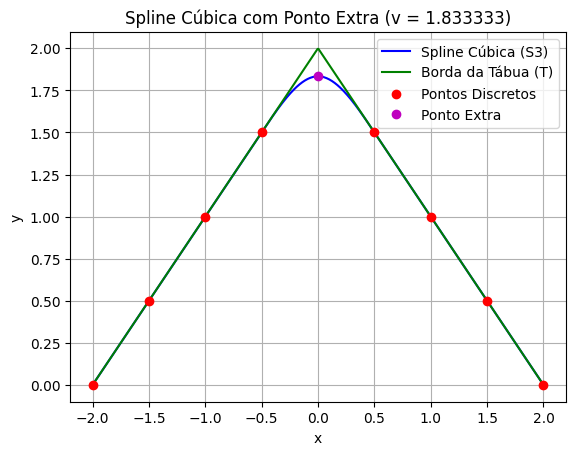

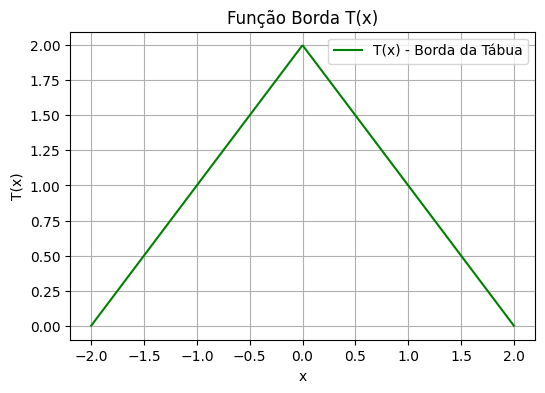

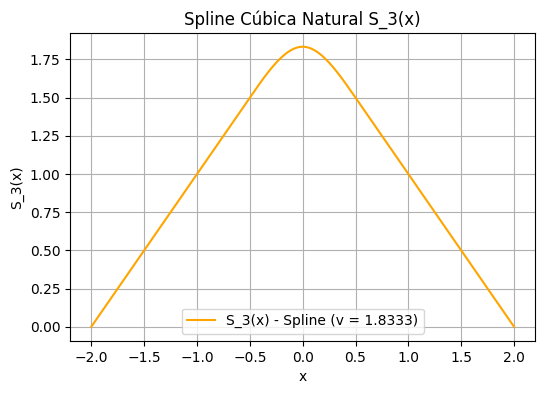

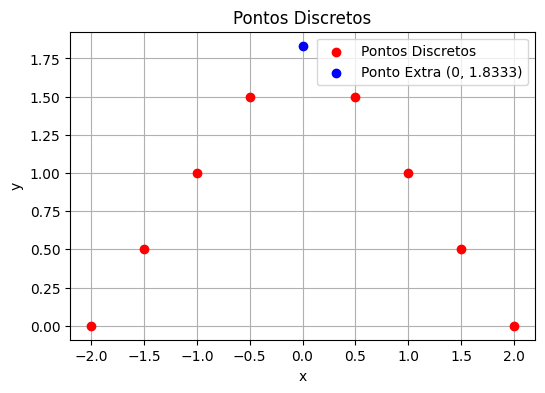

In [35]:
# Gerando o gráfico
x_plot= np.linspace(-2, 2, 500)
y_spline = spline_cubica(x_plot, np.insert(x, len(x)//2, 0), np.insert(y, len(y)//2, v_otimo))
y_borda = T(x_plot)

plt.plot(x_plot, y_spline, label='Spline Cúbica (S3)', color='blue')
plt.plot(x_plot, y_borda, label='Borda da Tábua (T)', color='green')
plt.scatter(x, y, color='red', zorder=5, label='Pontos Discretos')
plt.plot(0,v_otimo,'mo',label='Ponto Extra')
plt.title(f"Spline Cúbica com Ponto Extra (v = {v_otimo:.6f})")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

# grafico 1: função borda T(x)
plt.figure(figsize=(6, 4))
plt.plot(x_plot, T(x_plot), label='T(x) - Borda da Tábua', color='green')
plt.title('Função Borda T(x)')
plt.xlabel('x')
plt.ylabel('T(x)')
plt.grid(True)
plt.legend()
plt.show()

# grafico 2: spline cubica natural S_3(x)
plt.figure(figsize=(6, 4))
plt.plot(x_plot, y_spline, label=f'S_3(x) - Spline (v = {v_otimo:.4f})', color='orange')
plt.title('Spline Cúbica Natural S_3(x)')
plt.xlabel('x')
plt.ylabel('S_3(x)')
plt.grid(True)
plt.legend()
plt.show()

# grafico 3: pontos discretos
plt.figure(figsize=(6, 4))
plt.scatter(x, y, color='red', label='Pontos Discretos', zorder=5)
plt.scatter(0, v_otimo, color='blue', label=f'Ponto Extra (0, {v_otimo:.4f})', zorder=5)
plt.title('Pontos Discretos')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()
plt.show()